In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import viz

from fabapi import *
from tqdm import tqdm
from os import path

colors = viz.color_palette()
cnames_lin = 'green,blue,yellow,purple,red'.split(',')
lin_colors = [colors[c] for c in cnames_lin]

plt.style.use('style.mpl')

# Calculates contingency tables and plots them

Various modes of plotting, e.g. heatmap and bar plot. 

TODO: look for matches in the culture collections. We already know of one. 
https://gcm.wdcm.org/search

In [2]:
summary_df = pd.read_csv('../output/findabug/chemoauto_summary.csv')
species_results_df = pd.read_csv('../output/findabug/genomes_of_interest_metadata.csv')
# merge the gtdb taxonomic cols in summary_df
tax_cols = ['genome_id', 'gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_family', 'gtdb_genus', 'gtdb_species']
summary_annot_df = pd.merge(summary_df, species_results_df, on='genome_id')
summary_annot_df.genome_id.unique().size

summary_annot_df.to_csv('../output/findabug/chemoauto_summary_annot.csv', index=False)

summary_annot_df.columns

Index(['genome_id', 'rubisco', 'sbpase', 'fdh', 'h2ase', 'meoh', 'n2ase',
       'bmc', 'csos2', 'knallgas', 'alpha_csome', 'csome', 'rubisco_csome',
       'rubisco_csome_fdh', 'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase',
       'gtdb_version', 'gtdb_order', 'gtdb_domain', 'gtdb_phylum',
       'gtdb_class', 'gtdb_family', 'gtdb_genus', 'gtdb_species',
       'checkm_completeness', 'checkm_contamination', 'coding_bases',
       'coding_density', 'contig_count', 'gc_content', 'genome_size',
       'l50_contigs', 'l50_scaffolds', 'n50_contigs', 'n50_scaffolds',
       'longest_contig', 'longest_scaffold', 'mean_contig_length',
       'sec_trna_count', 'mean_scaffold_length', 'protein_count',
       'ncbi_genome_representation'],
      dtype='object')

In [3]:
order_counts = summary_annot_df.groupby('gtdb_order').size().sort_values(ascending=False)
my_orders = order_counts.head(10).index
for_plotting = summary_annot_df[summary_annot_df.gtdb_order.isin(my_orders)]
for_plotting.head()

,genome_id,rubisco,sbpase,fdh,h2ase,meoh,n2ase,bmc,csos2,knallgas,...,l50_scaffolds,n50_contigs,n50_scaffolds,longest_contig,longest_scaffold,mean_contig_length,sec_trna_count,mean_scaffold_length,protein_count,ncbi_genome_representation
0,GCA_000063505.1,True,False,False,False,False,False,True,True,False,...,1,2366980,2366980,2366980,2366980,2366980.0,0,2366980.0,2558,full
1,GCA_000063525.1,True,False,False,False,False,False,True,True,False,...,1,2224914,2224914,2224914,2224914,2224910.0,0,2224910.0,2540,full
2,GCA_000218705.1,True,False,False,False,False,False,True,True,False,...,1,118040,1569623,205335,1569623,43503.0,0,1569620.0,1992,full
3,GCA_000218745.1,True,False,False,False,False,False,True,True,False,...,1,118650,1484494,224989,1484494,52921.0,0,1484490.0,1763,full
5,GCA_000634115.1,True,False,False,False,False,False,True,True,False,...,7,69227,69227,198380,198380,6573.0,0,6602.0,1922,full


In [4]:
cols = ['rubisco_csome', 'rubisco_csome_fdh', 'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

# reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct

rubisco_csome            True                  
rubisco_csome_fdh       False       True       
rubisco_csome_h2ase     False True  False True 
rubisco_csome_fdh_h2ase False False False True 
gtdb_order                                     
Burkholderiales            19    28    12    13
Chromatiales                0    44     0     6
PCC-6307                  322    46     0     0
Ectothiorhodospirales      19     9     1     8
Thiotrichales               1     7     2     1
Acidithiobacillales         5     6     0     0
Thiomicrospirales          31     4     0     0
Rhizobiales                 4     1     1     2
Acidimicrobiales            2     0     3     0
Halothiobacillales          8     0     1     0

['Burkholderiales' 'Chromatiales' 'PCC-6307' 'Ectothiorhodospirales'
 'Thiotrichales' 'Acidithiobacillales' 'Thiomicrospirales' 'Rhizobiales'
 'Acidimicrobiales' 'Halothiobacillales']


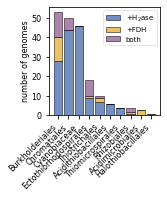

In [5]:
plt.figure(figsize=(2, 2))

# stacked bar values are along the rows below
bar_vals = ct.values[:, 1:]

# plot the stacked bar chart
xs = np.arange(len(ct.index))
plt.bar(xs, bar_vals[:, 0], color=lin_colors[1], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 1], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)

# relabel legend
plt.legend(['+H$_2$ase', '+FDH', 'both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
print(my_xticks)
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.ylabel('number of genomes')
plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order_small.pdf', bbox_inches='tight')
plt.savefig('../output/plots/top_hits_by_order_small.png', bbox_inches='tight')

plt.show()


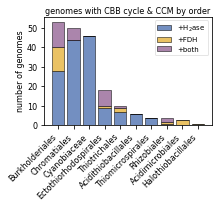

In [6]:
plt.figure(figsize=(3, 2))

# stacked bar values are along the rows below
bar_vals = ct.values[:, 1:]

# plot the stacked bar chart
xs = np.arange(len(ct.index))
bottom = np.zeros(len(ct.index))
for i in range(bar_vals.shape[1]):
    plt.bar(xs, bar_vals[:, i], bottom=bottom, color=lin_colors[i+1],
            edgecolor='k', lw=0.5)
    bottom += bar_vals[:, i]

#plt.bar(xs, bar_vals[:, 0], color=lin_colors[0], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 1], color=lin_colors[1], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 3], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)

# relabel legend
plt.legend(['+H$_2$ase', '+FDH', '+both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.title('genomes with CBB cycle & CCM by order')
plt.ylabel('number of genomes')
plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order.pdf', bbox_inches='tight')
plt.savefig('../output/plots/top_hits_by_order.png', bbox_inches='tight')

plt.show()


In [7]:
bar_vals

array([[28, 12, 13],
       [44,  0,  6],
       [46,  0,  0],
       [ 9,  1,  8],
       [ 7,  2,  1],
       [ 6,  0,  0],
       [ 4,  0,  0],
       [ 1,  1,  2],
       [ 0,  3,  0],
       [ 0,  1,  0]])

In [8]:
cols = ['rubisco_csome', 'fdh', 'h2ase', 'n2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

# reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct

rubisco_csome          True                                          
fdh                   False                   True                   
h2ase                 False       True        False       True       
n2ase                 False True  False True  False True  False True 
gtdb_order                                                           
Burkholderiales          19     0    18    10    12     0    11     2
Chromatiales              0     0     4    40     0     0     0     6
PCC-6307                322     0    44     2     0     0     0     0
Ectothiorhodospirales    15     4     8     1     1     0     7     1
Thiotrichales             1     0     2     5     2     0     0     1
Acidithiobacillales       5     0     1     5     0     0     0     0
Thiomicrospirales        31     0     4     0     0     0     0     0
Rhizobiales               4     0     0     1     1     0     0     2
Acidimicrobiales          2     0     0     0     3     0     0     0
Halothiobacillales        8     0     0     0     0     1     0     0

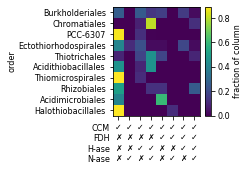

In [9]:
# make a heatmap from the above contingency table
plt.figure(figsize=(2, 2))

# Normalize counts per-column
norm_ct = ct.div(ct.sum(axis=1), axis=0)
plt.imshow(norm_ct.values, cmap='viridis')
cb = plt.colorbar(label='fraction of column')

my_yticks = norm_ct.index.values
# find PCC-6307, replace with its only family Cyanobiaceae
my_yticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'
plt.yticks(np.arange(len(norm_ct.index)), my_yticks, rotation=0)

# use unicode check to represent TRUE and unicode X to represent false 
subs = lambda x: "\u2713" if x else "\u2717"
my_xticks = ['\n'.join(map(subs, c)) for c in norm_ct.columns.values]

plt.xticks(np.arange(len(norm_ct.columns)), my_xticks, ha='center')

contingency_table_label = '\n'.join('CCM,FDH,H-ase,N-ase'.split(','))
plt.figtext(0.12, 0.07, contingency_table_label, va='top', ha='right', size=8)

plt.ylabel('order')
#plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order_heatmap.pdf', bbox_inches='tight')
plt.show()

In [10]:
norm_ct.columns

MultiIndex([(True, False, False, False),
            (True, False, False,  True),
            (True, False,  True, False),
            (True, False,  True,  True),
            (True,  True, False, False),
            (True,  True, False,  True),
            (True,  True,  True, False),
            (True,  True,  True,  True)],
           names=['rubisco_csome', 'fdh', 'h2ase', 'n2ase'])